### Utils

In [183]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt

In [184]:
conn = sql.connect("../../research/fuzzing-ndss-2026/prelim/railcar-results-seq-2-hour/metrics.db")
projects = [
    # "angular",
    # "canvg",
    "fast-xml-parser",
    # "jimp",
    # "jpeg-js",
    # "js-yaml",
    # "lit",
    # "lodash",
    "pako",
    # "protobufjs",
    "redux",
    "sharp",
    "tslib",
    # "turf",
    # "typescript",
    # "ua-parser-js",
    # "xml2js",
    # "xmldom",
]

In [187]:
def get_project_data(project, conn):
    df = pd.read_sql(f"select * from heartbeat where labels like '{project}%'", conn)

    # coverage percentage
    df['covpct'] = df['coverage'] * 100 / df['total_edges']
    
    # split labels into columns
    df = df.join(df['labels'].str.split(",", expand=True).rename(columns={0: "project", 1: "iter", 2: "mode", 3: "driver", 4: "schema"}))
    df['iter'] = df['iter'].astype(int)
    
    # # TODO: take start times from fuzzer-config.json?
    # # adjust timestamps so they start from 0
    # start_times = { mode: [df[(df['iter'] == x) & (df['mode'] == mode)]['timestamp'].iloc[0] for x in range(iterations)] for mode in modes }
    # start_offsets = df.apply(lambda row: start_times[row['mode']][row['iter']], axis=1)
    # df['timestamp'] = df['timestamp'] - start_offsets
    
    df = df.drop(["labels", "valid_execs", "valid_corpus", "corpus", "driver"], axis=1)
    return df

# Coverage Over Time

In [180]:
ITERATIONS = 3

In [181]:
def coverage_df_for_schema(project, schema, conn):
    df = get_project_data(project, conn)
    df = df[df['schema'] == schema]
    
    covs = []
    for i in range(ITERATIONS):
        cov = df[df['iter'] == i].set_index('timestamp')['coverage']
        cov = cov.reset_index()
        cov['timestamp'] = cov['timestamp'] - cov['timestamp'].iloc[0]
        covs.append(cov.set_index('timestamp')['coverage'].rename(i))

    df = pd.concat(covs, axis=1).interpolate(method="nearest").reset_index()
    df['timestamp'] = df['timestamp'] - df['timestamp'].iloc[0]
    df = df.melt(id_vars="timestamp", var_name="iteration", value_name="edges")
    
    return df

def coverage_plot_for_schema(project, schema, conn):
    df = coverage_df_for_schema(project, schema, conn)
    label = "Random" if schema == "None" else "Annotated"
    sns.lineplot(data=df, x="timestamp", y="edges", errorbar=("ci", 95), label=label)

def coverage_plot(project, conn):
    coverage_plot_for_schema(project, "None", conn)
    coverage_plot_for_schema(project, "typescript", conn)

    plt.title(project)
    plt.ylim(bottom=0)
    plt.xlabel("Time (s)")
    plt.ylabel("# edges")
    plt.tight_layout()
    plt.savefig(f"./img/coverage-over-time-{project}.png")
    plt.show()

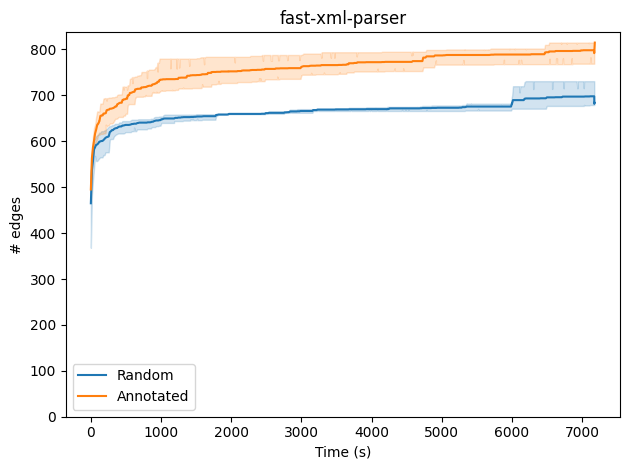

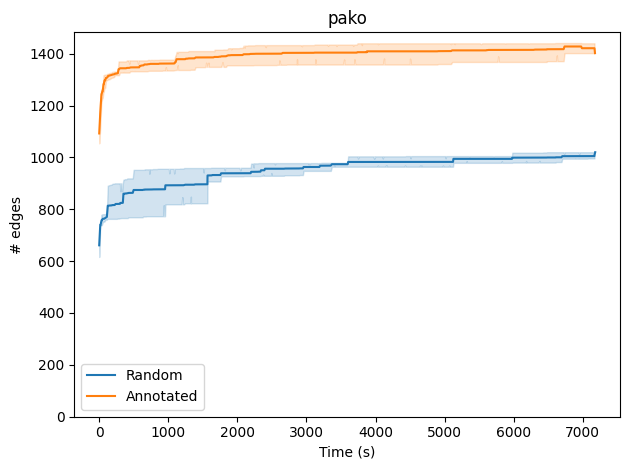

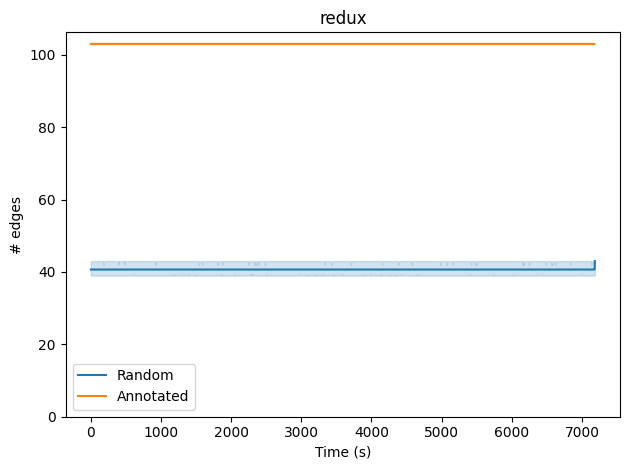

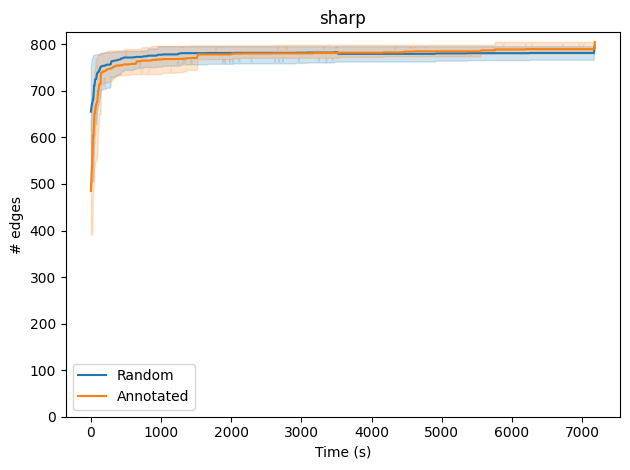

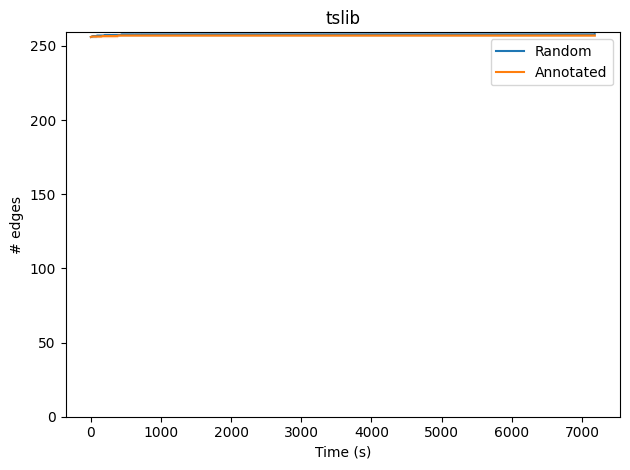

In [182]:
for project in projects:
    coverage_plot(project, conn)

# Coverage Matrix

# execs/s

In [236]:
es = []
for project in projects:
    df = get_project_data(project, conn)
    df['start'] = df.groupby(['iter', 'schema'])['timestamp'].transform("first")
    df['timestamp'] = df['timestamp'] - df['start']
    
    df = df.groupby(['schema', 'iter']).last()
    e = (df['execs'] / df['timestamp']).rename(project) # .reset_index().groupby('schema').mean()[0].rename(project)
    es.append(e)

pd.concat(es, axis=1).transpose()

schema                   None                             typescript  \
iter                        0            1            2            0   
fast-xml-parser   5605.252962  5650.585875  8240.746864  2127.758472   
pako                26.025212    23.901646    33.247036    37.451923   
redux            11082.609447  4240.153718  1638.868300  1787.997908   
sharp             1293.561274    49.088601  1099.935358   392.663788   
tslib             5850.493727  5932.892788  6383.856864  2870.147157   

schema                                     
iter                       1            2  
fast-xml-parser  3332.077694  2074.082241  
pako               13.246308    43.677640  
redux            2146.718031  1882.619426  
sharp              84.087526    79.686121  
tslib            4147.739421  7150.781289